# ANALYSIS OF MTOR

This notebook contains an analysis of the mTOR system described in Varusai and Nguyen, 2018.

We consider a model of the signaling network for mTOR, the mechanistic Target of Rapamycin (mTOR), an evolutionarily conserved network that controls key cellular processes, especially cell growth and metabolism. The signalling cascade is activated by a variety of receptor tyrosine kinases, most notably the Insulin Receptor.

<img src="images/mTOR-System.png"
     alt="Markdown Monster icon" 
     width="500" height="600"
     style="float: left; margin-right: 10px;" />

In [1]:
import controlSBML as ctl
from controlSBML.siso_closed_loop_designer import SISOClosedLoopDesigner

import control
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
ctl.__version__

'1.0.11'

# Problem Statement

The biological problem we address is controlling the concentration of phosphorylated mTORC1 through phosphorylated insulin. \ccite{varusai_dynamic_2018} describes this in terms of the species pIRS. The system we study has the single input $pIRS$ and the output mTORC1. It turns out that the mTOR system is bistable with respect to the insulin. Thus, our control objective is to regulate the outputs in the high insulin region where V1 $> 4$.
* Outputs: pmTORC1, pmTORC2
* Inputs: V1
* Control problem: regulate pmTORC1, pmTORC2

## mTOR Model

In [2]:
URL = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000823.2?filename=Varusai2018.xml"
INPUT_NAME = "IR"
INPUT_NAME = "pIRS"
OUTPUT_NAME = "pmTORC1"
SYSTEM = ctl.SBMLSystem(URL, input_names=[INPUT_NAME], output_names=[OUTPUT_NAME],
                       is_fixed_input_species=True)

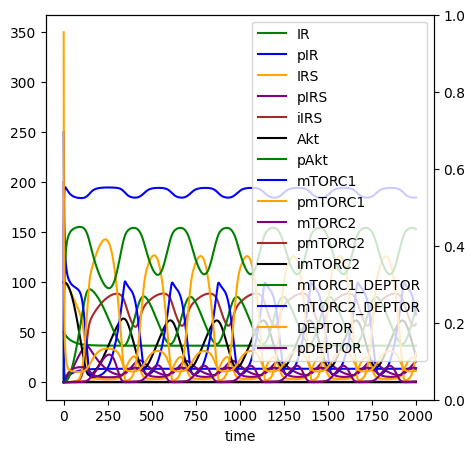

Text(0.5, 0, 'time')

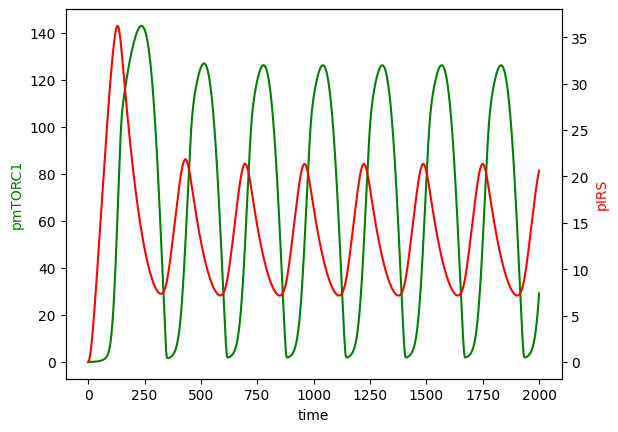

In [3]:
ts = SYSTEM.plotModel(figsize=(5,5), end_time=2000, markers=np.repeat("", 20))
for column in ts.columns:
    if not column in [INPUT_NAME, OUTPUT_NAME]:
        del ts[column]
times = ts.index/1000
plt.plot(times, ts[OUTPUT_NAME], color="green")
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(times, ts[INPUT_NAME], color="red")
ax.set_ylabel(OUTPUT_NAME, color="green")
ax2.set_ylabel(INPUT_NAME, color="red")
ax.set_xlabel("time")

In [4]:
ts["pmTORC1"]

miliseconds
0          0.000000e+00
100        2.929874e-08
200        3.989801e-07
300        1.731502e-06
400        4.723101e-06
               ...     
1999599    2.862567e+01
1999699    2.876358e+01
1999799    2.890192e+01
1999899    2.904070e+01
2000000    2.917990e+01
Name: pmTORC1, Length: 20000, dtype: float64

In [5]:
print(SYSTEM.getValidInputs())

floating_species:	IR, pIR, IRS, pIRS, iIRS, Akt, pAkt, mTORC1, pmTORC1, mTORC2, pmTORC2, imTORC2, mTORC1_DEPTOR, mTORC2_DEPTOR, DEPTOR, pDEPTOR

parameter:	V1, Km1, V2, Km2, k3c, Km3, V4, Km4, k5ca, Km5a, k5cb, Km5b, V6, Km6, k7c, Km7, V8, Km8, k9c, Km9, V10, Km10, k11ca, Km11a, k11cb, Km11b, V12, Km12, k13f, k13r, k14f, k14r, k15c, Km15, V16, Km16, ks17, kd18


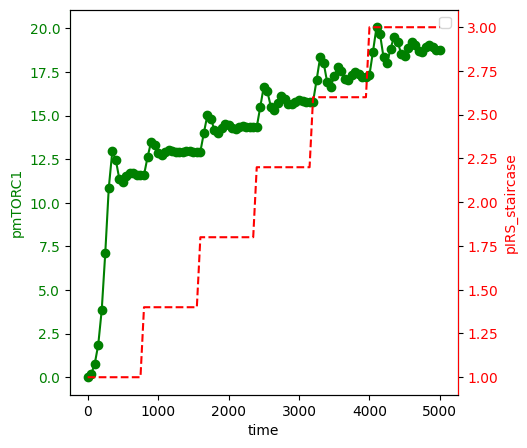

In [6]:
if False:
    # IR
    STAIRCASE = ctl.Staircase(initial_value=5, final_value=10, num_step=5)
    BUILDER = ctl.SISOTransferFunctionBuilder(SYSTEM)
    response_ts = BUILDER.makeStaircaseResponse(staircase=STAIRCASE, end_time=5000, points_per_time=10)
    BUILDER.plotStaircaseResponse(response_ts, figsize=(5,5))
else:
    # pIRS
    STAIRCASE = ctl.Staircase(initial_value=1, final_value=3, num_step=5)
    BUILDER = ctl.SISOTransferFunctionBuilder(SYSTEM)
    response_ts, _ = BUILDER.makeStaircaseResponse(staircase=STAIRCASE, end_time=5000, points_per_time=10)
    BUILDER.plotStaircaseResponse(response_ts, figsize=(5,5))

In [7]:
response_ts

,pmTORC1,pIRS_staircase
miliseconds,,
0,0.000000,1.0
50000,0.183399,1.0
100000,0.752463,1.0
150000,1.848268,1.0
200000,3.853209,1.0
...,...,...
4800000,18.907068,3.0
4850000,19.059071,3.0
4900000,18.935272,3.0


* The system is controllable in the region V1 $>4$, although the control decreases with larger V1 for both complexes.
* The operating region for V1 implies an operating region for pmTORC1 of 180 to 220 and for pmTORC2 0.7 to 1.0.

# System Identification

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Possible numerical instability: max abs residual is 12.709405



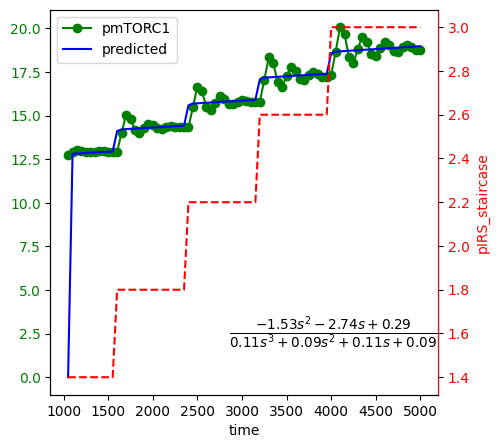

In [8]:
FITTER_RESULT = BUILDER.fitTransferFunction(num_numerator=3, num_denominator=4, staircase=STAIRCASE, 
                                            fit_start_time=1000, start_time=0, end_time=5000)
BUILDER.plotFitTransferFunction(FITTER_RESULT, figsize=(5,5))

In [9]:
FITTER_RESULT.transfer_function.poles()

array([ 3.58597964e-05+1.00531009j,  3.58597964e-05-1.00531009j,
       -8.78120907e-01+0.j        ])

# Testbed Construction

Here, we build a closed loop system where the open loop is the SBML model of the simulated system. Our has a PI controller.

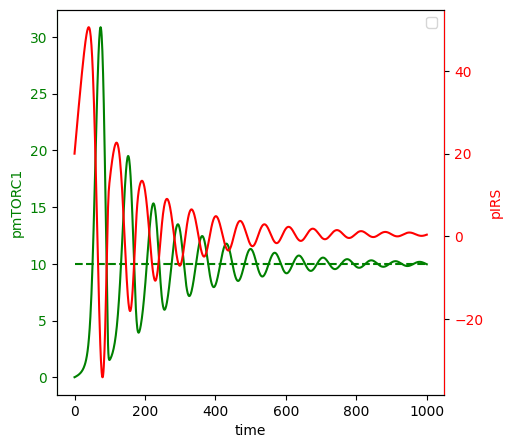

In [10]:
setpoint = 10
ts, builder = SYSTEM.simulateSISOClosedLoop(kp=2, ki=0.1, end_time=1000, is_steady_state=False, 
                                            setpoint=setpoint, num_point=1000, sign=-1,
                                            )
SYSTEM.plotSISOClosedLoop(ts, setpoint, figsize=(5,5), markers=[""])

We are able to simulate the closed loop system, but it's not easy to find design parameters such that: (a) settling times are short; (b) there is not overshoot; and (c) all concentrations are non-negative.

**Notes**
1. Need to use positive feedback. Not clear from the controlability curves.
2. Introducing even a little I behavior makes the controller worse.
3. There is a multimodal behavior of the network that radically changes the long term steady state values. Could this be analyzed by decomposing the system to have multiple tandem controllers. The first controls the effect of IR on pIRS; the second controls the effect of pIRS on pmTORC1.

# Design and Evaluation

In [11]:
times = np.linspace(0, 1000, 10000)
DESIGNER = SISOClosedLoopDesigner(SYSTEM, FITTER_RESULT.transfer_function, step_size=10, times=times)
DESIGNER.design(kp=2)
DESIGNER.evaluate(figsize=(5,5))

ValueError: Open loop transfer function is not stable

In [12]:
tf = FITTER_RESULT.transfer_function
tf.poles()

array([ 3.58597964e-05+1.00531009j,  3.58597964e-05-1.00531009j,
       -8.78120907e-01+0.j        ])